**Author**: Yap Jheng Khin

**FYP II Title**: Used car dealership web application

**Purpose**:
- This notebook analyzes the performance of ARF and TRF classification models with and without the influence of data drift or concept drift.
- Input: 
    - TRF model
    - Pre-trained ARF model in which its weights are transfered from the TRF model 
- Ouput
    - Performance analysis results
    - Pre-trained ARF model that is trained with drifted data
    - ARF model that is trained from scratch 

**Technical jargon**
1. ARF - Adaptive random forest
2. TRF - Traditional random forest

**Execution time**: At most 25 minutes in Jupyter Notebook.

# Setup

Ensure that the current Python interpreter path is correct. For example, if the **River conda environment** is named as **arf_conda_env**, the expected `sys.executable` should be C:\Users\User\miniconda3\envs\\**arf_conda_env**\\python.exe.

In [ ]:
import sys
print(sys.executable)

## Import

Import libraries.

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os

# User libraries
from arf_training import train_arf_cf
from rf_cf_performance_eval import get_running_metrics, measure_performance, plot_performance_graph, arf_predict, analyze_trees

Initialise constants and seed for reproducibility.

In [2]:
#Intialise a random number generator
# Source: https://towardsdatascience.com/stop-using-numpy-random-seed-581a9972805f
RANDOM_SEED = 2022
RANDOM_NUMBER_GENERATOR = np.random.default_rng(RANDOM_SEED)
DECIMAL_POINTS = 3

OUT_PARENT_DIR = 'outputs'
OUT_CHILD_DIR = 'cf_transfer_learning'
OUT_FOLDER_PATH = os.path.join(OUT_PARENT_DIR, OUT_CHILD_DIR) 

# Create directory if not exist
os.makedirs(OUT_FOLDER_PATH, exist_ok=True)

##  Data Setup

1. To verify the ARF's performance under concept drift, it would be suitable to use a more robust concept drift generator like `ConceptDriftStream`. The documentation of concept drift generator was found at [here](https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.data.ConceptDriftStream.html).

2. Instead of using the application data, the author used the [AGRAWAL stream generator](https://scikit-multiflow.readthedocs.io/en/stable/api/generated/skmultiflow.data.AGRAWALGenerator.html#skmultiflow.data.AGRAWALGenerator) as the experimental data since the concept drift stream generator was API-specific and don't handle general data structure like `numpy.ndarray` or `pandas.DataFrame`. In other words, `ConceptDriftStream` only supported its own data generator like `AGRAWALGenerator`.

3. To ensure the experimental data was as realistic as possible, the `perturbation` parameter was set to 0.10 to introduce some noise into the data.

`AGRAWALGenerator` generates:
- continuous features which are `salary`, `commission`, `age`, `hvalue` (house's value), `hyears` (# years of having house's ownership) and `loans` (amount of money to borrow).
- categorical features which are `elevel` (education level), `car` (owned car's brand), `zipcode` (town's zipcode).
- target variable that determines whether the loan application should be approved (`1`) or not (`0`). It's a classification task.

Load the data used in `FYP2_ARF_CF_Transfer_Learning.ipynb` for consistency.

1. The first 30,000 samples were **offline** data initially used in training algorithms. This data was used to test models' performance without concept drift. 
2. The last 30,000 samples were **online** data that experience concept drift over time. This data was used to test models' performance under concept drift. 
3. 5,000 samples out of 30,000 samples would be used to check model's generalisation error.

In [3]:
with open(os.path.join(OUT_FOLDER_PATH, 'exp_data_for_cf.npy'), 'rb') as f:
    y_train = np.load(f)
    y_test = np.load(f)
    y_train_drifted = np.load(f)
    y_test_drifted = np.load(f)
    X_train = np.load(f)
    X_test = np.load(f)
    X_train_drifted = np.load(f)
    X_test_drifted = np.load(f)

X_attrs = ['salary', 'commission', 'age', 'elevel', 'car', 'zipcode', 'hvalue', 'hyears', 'loan']
y_attr = ['target']
    
# Convert to dataframe
X_train = pd.DataFrame(X_train, columns = X_attrs)
X_test = pd.DataFrame(X_test, columns = X_attrs)
X_train_drifted = pd.DataFrame(X_train_drifted, columns = X_attrs)
X_test_drifted = pd.DataFrame(X_test_drifted, columns = X_attrs)

print(f'X_train shape {X_train.shape}')
print(f'y_train shape {y_train.shape}')
print(f'X_test shape {X_test.shape}')
print(f'y_test shape {y_test.shape}')
print(f'X_train_drifted shape {X_train_drifted.shape}')
print(f'y_train_drifted shape {y_train_drifted.shape}')
print(f'X_test_drifted shape {X_test_drifted.shape}')
print(f'y_test_drifted shape {y_test_drifted.shape}')

X_train shape (25000, 9)
y_train shape (25000,)
X_test shape (5000, 9)
y_test shape (5000,)
X_train_drifted shape (25000, 9)
y_train_drifted shape (25000,)
X_test_drifted shape (5000, 9)
y_test_drifted shape (5000,)


## Model Setup

Import the trained TRF model and the ARF model. Note that the pre-trained ARF model get its weights from the offline-trained TRF model instead of incrementally trained with the offline data.

In [4]:
# Load data preprocessor
with open(os.path.join(OUT_FOLDER_PATH, 'data_preprocessor.pkl'), 'rb') as f:
    data_pp = pickle.load(f)

# Load random forest
with open(os.path.join(OUT_FOLDER_PATH, 'trd_randf_cf_trained.pkl'), 'rb') as f:
    trf_cf = pickle.load(f)

# Load adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_cf_weight_transferred.pkl'), 'rb') as f:
    arf_cf = pickle.load(f)

# Performance without drift

This section is about evaluating the model performance in offline settings. The TRF is trained with 25,000 samples of offline train data. Then, the weights of TRF is transfered to the ARF. The train performance and generalization performance of ARF and TRF is evaluated using the next 5,000 samples of offline test data. The purpose of this section is to prove that the <u>offline performance of adaptive random forest classifier is as good as or better than traditional random forest classifier</u>.

The transfer learning algorithm is demonstrated at *FYP2_ARF_CF_Transfer_Learning.ipynb*. 

In [5]:
cat_attrs = ['car', 'zipcode']
num_attrs = ['hvalue', 'salary', 'loan', 'commission', 'elevel', 'hyears', 'age']

`cf_pred_res` is a dictionary that stores models, predictions and metrics for four different subsets of data.

The four subset of data are:
- Train data without drift.
- Test data without drift.
- Train data with drift.
- Test data with drift.

In [6]:
MODEL_TYPES = ['TRF', 'ARF_pretrained', 'ARF_fr_scratch']
cf_pred_res = {}
# First level
CONDITIONS = ['normal', 'drift']
# Second level
DATA_TYPES = ['train', 'test']
# Third level
RECORD_TYPES = ['model', 'pred', 'pred_proba', 'fpr', 'tpr', 'roc_auc', 'label']

# Initialise cf_pred_res
for condition in CONDITIONS:
    cf_pred_res[condition] = {}
    for data_type in DATA_TYPES:
        cf_pred_res[condition][data_type] = {}
        for record_type in RECORD_TYPES:
            cf_pred_res[condition][data_type][record_type] = {}
            
cf_pred_res

{'normal': {'train': {'model': {},
   'pred': {},
   'pred_proba': {},
   'fpr': {},
   'tpr': {},
   'roc_auc': {},
   'label': {}},
  'test': {'model': {},
   'pred': {},
   'pred_proba': {},
   'fpr': {},
   'tpr': {},
   'roc_auc': {},
   'label': {}}},
 'drift': {'train': {'model': {},
   'pred': {},
   'pred_proba': {},
   'fpr': {},
   'tpr': {},
   'roc_auc': {},
   'label': {}},
  'test': {'model': {},
   'pred': {},
   'pred_proba': {},
   'fpr': {},
   'tpr': {},
   'roc_auc': {},
   'label': {}}}}

## Train adaptive random forest

Before measuring the performance, a new ARF is trained from scratch to serve as a baseline performance for pre-trained ARF.  

In [7]:
# Load and initialise a new adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_cf_weight_transferred.pkl'), 'rb') as f:
    arf_cf_tmp = pickle.load(f)

# Note that the model is brand new as indicated by the emtpy data attribute
new_arf_cf = arf_cf_tmp.clone()
new_arf_cf.__dict__

X_train_pp = data_pp.preprocess(X_train)

# Train the model using the offline data
new_arf_cf, runninng_metrics_new_arf_train = train_arf_cf(new_arf_cf, X_train_pp, y_train)

Training adaptive random forest algorithm: 100%|█| 25000/25000 [03:12<00:00, 12


Below shows the number of nodes and height of each base learners in the respective models. The number of nodes and maximum height in **TRF** and **ARF_fr_scratch** are all the same since the training weights are directly transferred from one to another.

In [8]:
models = {
    'TRF': trf_cf,
    'ARF_fr_scratch': new_arf_cf,
    'ARF_pretrained': arf_cf
}

analyze_trees(models)

1    2     3    4     5     6     7     8   \
Model          Properties                                                  
TRF            total_nodes   907  683   867  599   921   885   731   897   
               max_height     15   15    15   15    15    15    15    15   
ARF_fr_scratch total_nodes   119   71     5  103   133   263   113   101   
               max_height     12   10     2   12    14    22    12    15   
ARF_pretrained total_nodes  1205  965  1033  979  1117  1241  1197  1217   
               max_height     20   20    20   20    20    20    20    20   

                              9     10    11    12   13    14    15  
Model          Properties                                            
TRF            total_nodes   797   795   793   873  697   733   819  
               max_height     15    15    15    15   15    15    15  
ARF_fr_scratch total_nodes    53     1    47    27   99   123    41  
               max_height     10     0     9     8   12    12     9  
ARF_pretrained total_nodes  1041  1185  1211  1093  995  1081  1065  
               max_height     20    20    20    20   20    20    20


Total nodes:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,907,683,867,599,921,885,731,897,797,795,793,873,697,733,819
ARF_fr_scratch,119,71,5,103,133,263,113,101,53,1,47,27,99,123,41
ARF_pretrained,1205,965,1033,979,1117,1241,1197,1217,1041,1185,1211,1093,995,1081,1065



Maximum height:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
ARF_fr_scratch,12,10,2,12,14,22,12,15,10,0,9,8,12,12,9
ARF_pretrained,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20


## Train performance

The output compares the training performance between TRF and ARF in the offline setting. It can be inferred that the transfer learning process is **successful** as the ROC AUC score of both **TRF** and **pretrained ARF** differs no more than 3%. There is a slight difference in the performance since the leaf prediction mechanisms in the **TRF** and **ARF** are different. 


On the other hand, the training performance of **ARF that is trained from scratch** is the lowest with the ROC AUC score difference of 5% as compared to **pretrained ARF**. However, the result cannot guarantee the superiority of the **transfer learning algorithm** for other datasets. For further details, please refer to *FYP2_Lead_Scoring_Model_Training.ipynb*. Summarizing from the file, the initial performance boost provided by transfer learning varies from one dataset to another.

Performing predictions: 100%|███████████| 25000/25000 [01:01<00:00, 407.24it/s]



Classification results summary table by model type:


Metrics      precision                               recall                 \
Model type         TRF ARF_pretrained ARF_fr_scratch    TRF ARF_pretrained   
0.0              0.891          0.881          0.879  0.813          0.888   
1.0              0.827          0.886          0.827  0.901          0.880   
macro avg        0.859          0.884          0.853  0.857          0.884   
weighted avg     0.859          0.884          0.853  0.857          0.884   

Metrics                     f1-score                                support  \
Model type   ARF_fr_scratch      TRF ARF_pretrained ARF_fr_scratch      TRF   
0.0                   0.814    0.850          0.884          0.846  12515.0   
1.0                   0.888    0.863          0.883          0.856  12485.0   
macro avg             0.851    0.856          0.884          0.851  25000.0   
weighted avg          0.851    0.856          0.884          0.851  25000.0   

Metrics                                     
Model type   ARF_pretrained ARF_fr_scratch  
0.0                 12515.0        12515.0  
1.0                 12485.0        12485.0  
macro avg           25000.0        25000.0  
weighted avg        25000.0        25000.0


Comparing precision:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.891,0.881,0.879,0.010,0.012,0.002
1.0,0.827,0.886,0.827,-0.059,0.000,0.059
macro avg,0.859,0.884,0.853,-0.025,0.006,0.031
weighted avg,0.859,0.884,0.853,-0.025,0.006,0.031



Comparing recall:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.813,0.888,0.814,-0.075,-0.001,0.074
1.0,0.901,0.880,0.888,0.021,0.013,-0.008
macro avg,0.857,0.884,0.851,-0.027,0.006,0.033
weighted avg,0.857,0.884,0.851,-0.027,0.006,0.033



Comparing f1-score:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.850,0.884,0.846,-0.034,0.004,0.038
1.0,0.863,0.883,0.856,-0.020,0.007,0.027
macro avg,0.856,0.884,0.851,-0.028,0.005,0.033
weighted avg,0.856,0.884,0.851,-0.028,0.005,0.033


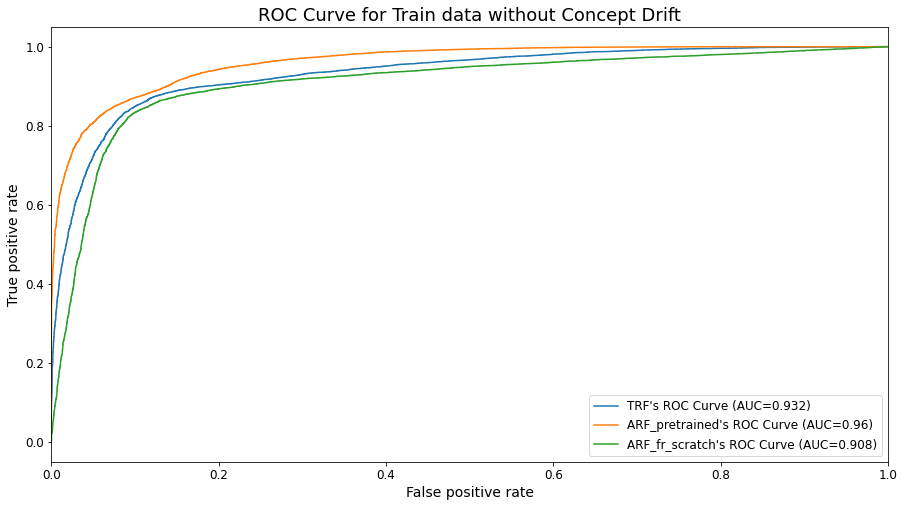

In [9]:
cf_pred_res['normal']['train']['model']['TRF'] = trf_cf
cf_pred_res['normal']['train']['model']['ARF_pretrained'] = arf_cf
cf_pred_res['normal']['train']['model']['ARF_fr_scratch'] = new_arf_cf

params = {
    'pred_records': cf_pred_res['normal']['train'],
    'X': X_train,
    'y': y_train,
    'data_pp': data_pp,
    'plot_title': 'ROC Curve for Train data without Concept Drift'
}

measure_performance(**params)

## Test performance

The output compares the generalization performance between TRF and ARF in the offline setting. The output again proves that transfer learning process is **successful** as the ROC AUC score of both **TRF** and **pretrained ARF** differs no more than 1%. On the other hand, the generalization performance of **ARF that is trained from scratch** is the lowest with a ROC AUC score difference of 2% as compared to **pretrained ARF**. 

Performing predictions: 100%|█████████████| 5000/5000 [00:12<00:00, 404.89it/s]



Classification results summary table by model type:


Metrics      precision                               recall                 \
Model type         TRF ARF_pretrained ARF_fr_scratch    TRF ARF_pretrained   
0.0              0.893           0.87          0.874  0.811          0.868   
1.0              0.829           0.87          0.817  0.904          0.872   
macro avg        0.861           0.87          0.845  0.858          0.870   
weighted avg     0.861           0.87          0.845  0.858          0.870   

Metrics                     f1-score                               support  \
Model type   ARF_fr_scratch      TRF ARF_pretrained ARF_fr_scratch     TRF   
0.0                   0.799    0.850          0.869          0.834  2484.0   
1.0                   0.886    0.865          0.871          0.850  2516.0   
macro avg             0.842    0.857          0.870          0.842  5000.0   
weighted avg          0.843    0.857          0.870          0.842  5000.0   

Metrics                                     
Model type   ARF_pretrained ARF_fr_scratch  
0.0                  2484.0         2484.0  
1.0                  2516.0         2516.0  
macro avg            5000.0         5000.0  
weighted avg         5000.0         5000.0


Comparing precision:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.893,0.87,0.874,0.023,0.019,-0.004
1.0,0.829,0.87,0.817,-0.041,0.012,0.053
macro avg,0.861,0.87,0.845,-0.009,0.016,0.025
weighted avg,0.861,0.87,0.845,-0.009,0.016,0.025



Comparing recall:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.811,0.868,0.799,-0.057,0.012,0.069
1.0,0.904,0.872,0.886,0.032,0.018,-0.014
macro avg,0.858,0.870,0.842,-0.012,0.016,0.028
weighted avg,0.858,0.870,0.843,-0.012,0.015,0.027



Comparing f1-score:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.850,0.869,0.834,-0.019,0.016,0.035
1.0,0.865,0.871,0.850,-0.006,0.015,0.021
macro avg,0.857,0.870,0.842,-0.013,0.015,0.028
weighted avg,0.857,0.870,0.842,-0.013,0.015,0.028


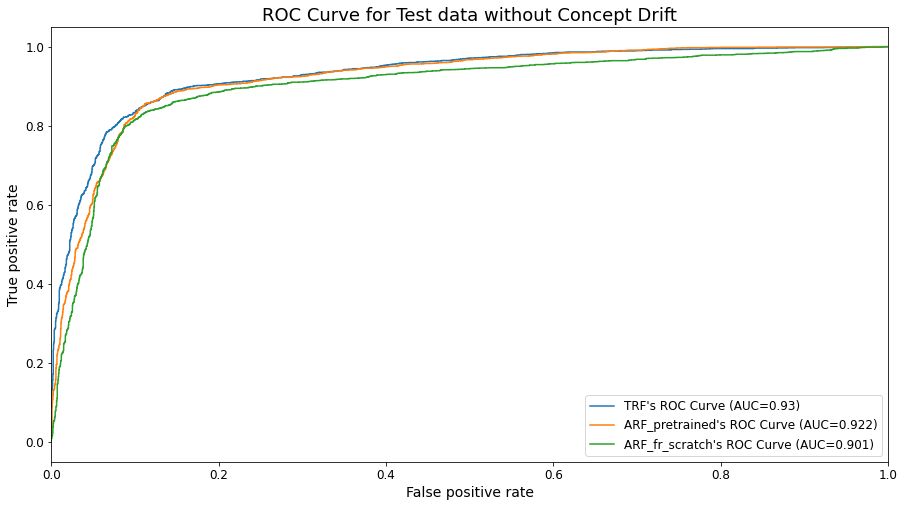

In [10]:
cf_pred_res['normal']['test']['model']['TRF'] = trf_cf
cf_pred_res['normal']['test']['model']['ARF_pretrained'] = arf_cf
cf_pred_res['normal']['test']['model']['ARF_fr_scratch'] = new_arf_cf

params = {
    'pred_records': cf_pred_res['normal']['test'],
    'X': X_test,
    'y': y_test,
    'data_pp': data_pp,
    'plot_title': 'ROC Curve for Test data without Concept Drift'
}

measure_performance(**params)

# Performance with drift

This section is about evaluating the model performance in online settings where drifted data is frequently encountered. The ARFs (*online models*) are incrementally trained and evaluated with the 25,000 samples of drifted train data, while the TRF (*offline model*) is only evaluated using the same drifted train data. Finally, the generalization performance of ARFs and TRF are evaluated using the last 5,000 samples of drifted test data. The purpose of this section is to prove that the <u>online performance of adaptive random forest classifier is better than traditional random forest classifier</u>.

## Train adaptive random forest

Incrementally train and evaluate both the adaptive random forest models.

In [11]:
# Preprocess data
X_train_drifted_pp = data_pp.preprocess(X_train_drifted)

In [12]:
trained_arf_cf_fr_scratch, runninng_metrics_new_arf_train_drifted = \
train_arf_cf(new_arf_cf, X_train_drifted_pp, y_train_drifted)

# Save the adaptive random forest that is trained from scratch
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_cf_trained_from_scratch.pkl'), 'wb') as f:
    pickle.dump(trained_arf_cf_fr_scratch, f)

Training adaptive random forest algorithm: 100%|█| 25000/25000 [03:28<00:00, 11


In [13]:
trained_arf_cf, runninng_metrics_arf_train_drifted = train_arf_cf(arf_cf, X_train_drifted_pp, y_train_drifted)

# Save the pre-trained adaptive random forest
with open(os.path.join(OUT_FOLDER_PATH, 'adap_randf_cf_trained.pkl'), 'wb') as f:
    pickle.dump(trained_arf_cf, f)

Training adaptive random forest algorithm: 100%|█| 25000/25000 [04:46<00:00, 87


Below shows the number of nodes and height of each base learners in the respective models. It can be observed that the number of nodes and the height of some **pre-trained ARF**'s base learners are lower than **TRF**. It is because the Hoeffding tree algorithm has replaced some initial pre-trained trees with the corresponding background trees in respond to data/concept drift.

In [14]:
models = {
    'TRF': trf_cf,
    'ARF_fr_scratch': trained_arf_cf_fr_scratch,
    'ARF_pretrained': trained_arf_cf
}

analyze_trees(models)

1    2    3    4    5    6    7    8    9    10  \
Model          Properties                                                      
TRF            total_nodes  907  683  867  599  921  885  731  897  797  795   
               max_height    15   15   15   15   15   15   15   15   15   15   
ARF_fr_scratch total_nodes   57  239   59    5   91   15   47  177   17  143   
               max_height    10   16   14    2   13    5   10   14    5   14   
ARF_pretrained total_nodes   41   59   55   29  241   15  101   49  139   49   
               max_height     7   11   11    7   18    4   11   10   15   11   

                             11   12   13   14   15  
Model          Properties                            
TRF            total_nodes  793  873  697  733  819  
               max_height    15   15   15   15   15  
ARF_fr_scratch total_nodes   27   85  185   39   59  
               max_height     8   18   19    9   15  
ARF_pretrained total_nodes  189  139   65   35  109  
               max_height    16   17    8    9   15


Total nodes:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,907,683,867,599,921,885,731,897,797,795,793,873,697,733,819
ARF_fr_scratch,57,239,59,5,91,15,47,177,17,143,27,85,185,39,59
ARF_pretrained,41,59,55,29,241,15,101,49,139,49,189,139,65,35,109



Maximum height:



,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
Model,,,,,,,,,,,,,,,
TRF,15,15,15,15,15,15,15,15,15,15,15,15,15,15,15
ARF_fr_scratch,10,16,14,2,13,5,10,14,5,14,8,18,19,9,15
ARF_pretrained,7,11,11,7,18,4,11,10,15,11,16,17,8,9,15


## Train performance

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Offline Train ROC AUC</th>
        <th style="text-align:left;">Online Train ROC AUC</th>
        <th style="text-align:left;">Difference</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.932</td>
        <td style="text-align:center;">0.680</td>
        <td style="text-align:center;">-0.252</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.960</td>
        <td style="text-align:center;">0.833</td>
        <td style="text-align:center;">-0.127</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.908</td>
        <td style="text-align:center;">0.755</td>
        <td style="text-align:center;">-0.153</td>
    </tr>
</table>

The output compares the training performance between TRF and ARF in the online setting. Due to drift, all of the models' performance are affected. The train performance of **TRF** has the most impact with a drop of 25% as compared to offline one. The **pre-trained ARF**'s online train performance drops about 13% while the performance for **ARF that is trained from scratch** drops about 15%. It can be deduced that ARF algorithm is more robust against drift as compared to TRF algorithm. 


Among the ARF models, the training performance of **pre-trained ARF** is better than **ARF that is trained from scratch** with a ROC AUC score difference of 8%. However, the result cannot guarantee the superiority of the transfer learning algorithm for other datasets. It is because the transfer learning algorithm might not give any significant performance improvement for some datasets. For further details, please refer to *FYP2_Lead_Scoring_Model_Training.ipynb*. Summarizing from the file, the initial performance boost provided by transfer learning varies from one dataset to another.

Performing predictions: 100%|███████████| 25000/25000 [01:00<00:00, 414.81it/s]



Classification results summary table by model type:


Metrics      precision                               recall                 \
Model type         TRF ARF_pretrained ARF_fr_scratch    TRF ARF_pretrained   
0.0              0.577          0.736          0.652  0.630          0.817   
1.0              0.592          0.795          0.745  0.537          0.707   
macro avg        0.584          0.765          0.699  0.584          0.762   
weighted avg     0.584          0.765          0.699  0.584          0.762   

Metrics                     f1-score                                support  \
Model type   ARF_fr_scratch      TRF ARF_pretrained ARF_fr_scratch      TRF   
0.0                   0.805    0.602          0.775          0.721  12500.0   
1.0                   0.571    0.563          0.748          0.646  12500.0   
macro avg             0.688    0.583          0.762          0.683  25000.0   
weighted avg          0.688    0.583          0.762          0.683  25000.0   

Metrics                                     
Model type   ARF_pretrained ARF_fr_scratch  
0.0                 12500.0        12500.0  
1.0                 12500.0        12500.0  
macro avg           25000.0        25000.0  
weighted avg        25000.0        25000.0


Comparing precision:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.577,0.736,0.652,-0.159,-0.075,0.084
1.0,0.592,0.795,0.745,-0.203,-0.153,0.050
macro avg,0.584,0.765,0.699,-0.181,-0.115,0.066
weighted avg,0.584,0.765,0.699,-0.181,-0.115,0.066



Comparing recall:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.630,0.817,0.805,-0.187,-0.175,0.012
1.0,0.537,0.707,0.571,-0.170,-0.034,0.136
macro avg,0.584,0.762,0.688,-0.178,-0.104,0.074
weighted avg,0.584,0.762,0.688,-0.178,-0.104,0.074



Comparing f1-score:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.602,0.775,0.721,-0.173,-0.119,0.054
1.0,0.563,0.748,0.646,-0.185,-0.083,0.102
macro avg,0.583,0.762,0.683,-0.179,-0.100,0.079
weighted avg,0.583,0.762,0.683,-0.179,-0.100,0.079


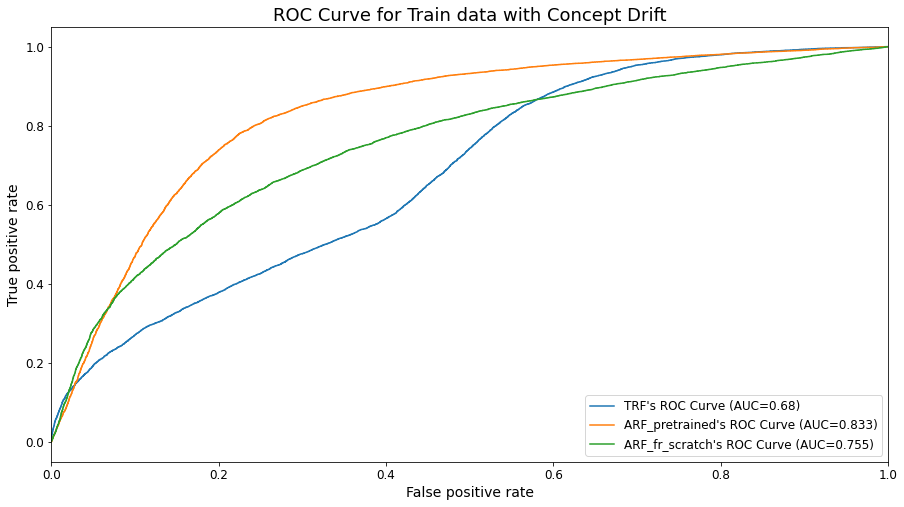

In [15]:
cf_pred_res['drift']['train']['model']['TRF'] = trf_cf
cf_pred_res['drift']['train']['model']['ARF_pretrained'] = trained_arf_cf
cf_pred_res['drift']['train']['model']['ARF_fr_scratch'] = trained_arf_cf_fr_scratch

params = {
    'pred_records': cf_pred_res['drift']['train'],
    'X': X_train_drifted,
    'y': y_train_drifted,
    'data_pp': data_pp,
    'plot_title': 'ROC Curve for Train data with Concept Drift'
}

measure_performance(**params)

## Test performance

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Offline Test ROC AUC</th>
        <th style="text-align:left;">Online Test ROC AUC</th>
        <th style="text-align:left;">Difference</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.930</td>
        <td style="text-align:center;">0.641</td>
        <td style="text-align:center;">-0.289</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.922</td>
        <td style="text-align:center;">0.899</td>
        <td style="text-align:center;">-0.023</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.901</td>
        <td style="text-align:center;">0.800</td>
        <td style="text-align:center;">-0.101</td>
    </tr>
</table>

The output below compares the online generalization performance between TRF and ARF. The table above displays the difference between offline and online generalization performance of each model. Due to drift, the online generalization performance of **TRF** drops about 29% as compared to offline one. The **pre-trained ARF**'s online generalization performance drops about 2% while the performance for **ARF that is trained from scratch** drops about 10%. It can be deduced that ARF algorithm is robust against drift but not TRF algorithm. 


On the other hand, the online generalization performance of the **pre-trained ARF** is better than **ARF that is trained from scratch** with a difference of 10%. Again, the result cannot guarantee the superiority of the transfer learning algorithm for other datasets.

Performing predictions: 100%|█████████████| 5000/5000 [00:12<00:00, 407.24it/s]



Classification results summary table by model type:


Metrics      precision                               recall                 \
Model type         TRF ARF_pretrained ARF_fr_scratch    TRF ARF_pretrained   
0.0              0.520          0.776          0.676  0.592          0.885   
1.0              0.526          0.866          0.803  0.453          0.745   
macro avg        0.523          0.821          0.740  0.522          0.815   
weighted avg     0.523          0.821          0.740  0.522          0.815   

Metrics                     f1-score                               support  \
Model type   ARF_fr_scratch      TRF ARF_pretrained ARF_fr_scratch     TRF   
0.0                   0.855    0.553          0.827          0.755  2501.0   
1.0                   0.590    0.486          0.801          0.680  2499.0   
macro avg             0.723    0.520          0.814          0.718  5000.0   
weighted avg          0.723    0.520          0.814          0.718  5000.0   

Metrics                                     
Model type   ARF_pretrained ARF_fr_scratch  
0.0                  2501.0         2501.0  
1.0                  2499.0         2499.0  
macro avg            5000.0         5000.0  
weighted avg         5000.0         5000.0


Comparing precision:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.520,0.776,0.676,-0.256,-0.156,0.100
1.0,0.526,0.866,0.803,-0.340,-0.277,0.063
macro avg,0.523,0.821,0.740,-0.298,-0.217,0.081
weighted avg,0.523,0.821,0.740,-0.298,-0.217,0.081



Comparing recall:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.592,0.885,0.855,-0.293,-0.263,0.030
1.0,0.453,0.745,0.590,-0.292,-0.137,0.155
macro avg,0.522,0.815,0.723,-0.293,-0.201,0.092
weighted avg,0.522,0.815,0.723,-0.293,-0.201,0.092



Comparing f1-score:


Model type,TRF,ARF_pretrained,ARF_fr_scratch,TRF - ARF_pretrained,TRF - ARF_fr_scratch,ARF_pretrained - ARF_fr_scratch
0.0,0.553,0.827,0.755,-0.274,-0.202,0.072
1.0,0.486,0.801,0.680,-0.315,-0.194,0.121
macro avg,0.520,0.814,0.718,-0.294,-0.198,0.096
weighted avg,0.520,0.814,0.718,-0.294,-0.198,0.096


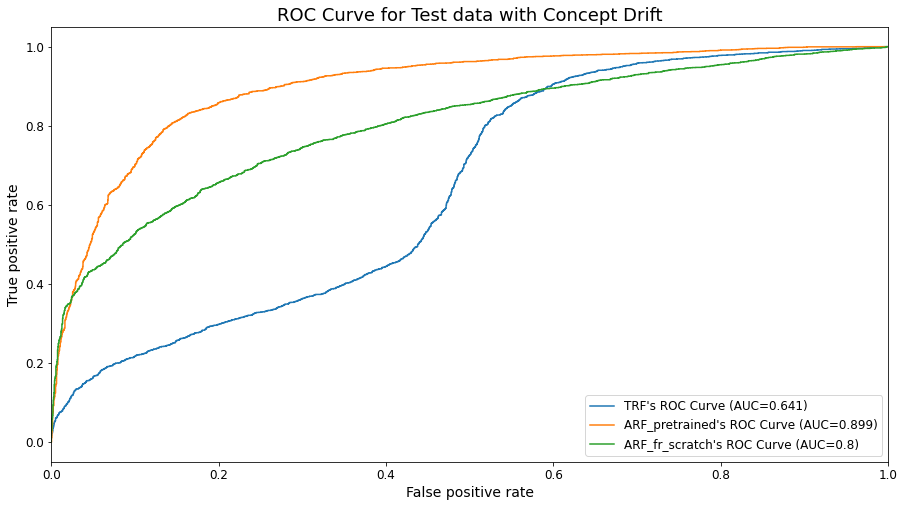

In [16]:
cf_pred_res['drift']['test']['model']['TRF'] = trf_cf
cf_pred_res['drift']['test']['model']['ARF_pretrained'] = trained_arf_cf
cf_pred_res['drift']['test']['model']['ARF_fr_scratch'] = trained_arf_cf_fr_scratch

params = {
    'pred_records': cf_pred_res['drift']['test'],
    'X': X_test_drifted,
    'y': y_test_drifted,
    'data_pp': data_pp,
    'plot_title': 'ROC Curve for Test data with Concept Drift'
}

measure_performance(**params)

The difference of ROC AUC in the offline and online set is calculated by substracting the training ROC AUC score with the testing ROC AUC score for each set.

<table>
    <tr>
        <th style="text-align:left;">Model type</th>
        <th style="text-align:left;">Diff ROC AUC in Offline set</th>
        <th style="text-align:left;">Diff ROC AUC in Online set</th>
    </tr>
    <tr>
        <td style="text-align:left;">TRF</td>
        <td style="text-align:center;">0.932 - 0.930 = 0.002</td>
        <td style="text-align:center;">0.680 - 0.641 = 0.039</td>
    </tr>
    <tr>
        <td style="text-align:left;">Pre-trained ARF</td>
        <td style="text-align:center;">0.960 - 0.922 = 0.038</td>
        <td style="text-align:center;">0.833 - 0.899 = -0.066</td>
    </tr>
    <tr>
        <td style="text-align:left;">ARF trained from scratch</td>
        <td style="text-align:center;">0.908 - 0.901 = 0.007</td>
        <td style="text-align:center;">0.755 - 0.800 = -0.045</td>
    </tr>
</table>

The result above shows the ARFs are free from overfitting issue when training with online samples.

# Performance Overview

To visualize the performance of ARF and TRF over time, the models' running metrics are computed. The running metrics are calculated in four different stages, which are (*1*) offline train settings, (*2*) offline test settings, (*3*) online train settings, and (*4*) online test settings. By separating the calculation of running metrics into stages, the graph can showed more useful information by comparing performance across stages.

Besides TRF, the performance of two different ARFs are visualized. The first ARF is the model that incrementally trained with both offline train data and online train data. The second ARF is the model that get its weights from offline-trained TRF before incrementally trained with online train data. The purpose of comparison is to prove that second ARF performs better than first ARF during offline training. 

Below shows the detailed calculation of the running metrics:
1. Traditional random forest
    - For every 100 samples, get the predictions from the sample before updating the classification metrics containing the previous predictions.
    

2. Pre-trained ARF
    - **Offline train set**: Running metrics are not available since the weights are directly transferred. Thus, the calculation method is the same as traditional random forest.
    - **Online train set**: The running metrics are directly retrieved from the model training process. The running metrics are updated for every 100 training samples.
    - **Offline test and online test set**: The calculation method is the same as traditional random forest.


3. ARF that is trained from scratch
    - **Offline train and online train set**: The running metrics are directly retrieved from the model training process. The running metrics are updated for every 100 training samples.
    - **Offline test and online test set**: The calculation method is the same as traditional random forest.

Calculate the running metrics for the TRF model.

In [17]:
DATA_INTERVAL = 100

running_metrics_trf = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'roc_auc': []
}

# Stage 1
params = {
    'running_metrics': running_metrics_trf,
    'pred_records': cf_pred_res['normal']['train'],
    'model_type': 'TRF',
    'y_true': y_train,
    'data_interval': DATA_INTERVAL
}

get_running_metrics(**params)

# Stage 2
params['pred_records'] = cf_pred_res['normal']['test']
params['y_true'] = y_test

get_running_metrics(**params)

# Stage 3
params['pred_records'] = cf_pred_res['drift']['train']
params['y_true'] = y_train_drifted

get_running_metrics(**params)

# Stage 4
params['pred_records'] = cf_pred_res['drift']['test']
params['y_true'] = y_test_drifted

get_running_metrics(**params)

Calculating running metrics for TRF: 100%|█████| 50/50 [00:00<00:00, 63.00it/s]


Calculate the running metrics for the ARF model (that has undergone transfer learning).

In [18]:
running_metrics_arf = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'roc_auc': []
}

# Stage 1
params = {
    'running_metrics': running_metrics_arf,
    'pred_records': cf_pred_res['normal']['train'],
    'model_type': 'ARF_pretrained',
    'y_true': y_train,
    'data_interval': DATA_INTERVAL
}

get_running_metrics(**params)

# Stage 2
params['pred_records'] = cf_pred_res['normal']['test']
params['y_true'] = y_test

get_running_metrics(**params)

# Stage 3
for metric_name in running_metrics_arf:
    tmp = runninng_metrics_arf_train_drifted[metric_name]
    running_metrics_arf[metric_name] = running_metrics_arf[metric_name] + tmp

# Stage 4
params['pred_records'] = cf_pred_res['drift']['test']
params['y_true'] = y_test_drifted

get_running_metrics(**params)

Calculating running metrics for ARF_pretrained: 100%|█| 250/250 [00:20<00:00, 1
Calculating running metrics for ARF_pretrained: 100%|█| 50/50 [00:01<00:00, 44.
Calculating running metrics for ARF_pretrained: 100%|█| 50/50 [00:01<00:00, 46.


Calculate the running metrics for the ARF model that is trained from scratch.

In [19]:
running_metrics_new_arf = {
    'f1_score': [],
    'precision': [],
    'recall': [],
    'roc_auc': []
}

# Stage 1
# Update offline train metrics
for metric_name in running_metrics_new_arf:
    tmp = runninng_metrics_new_arf_train[metric_name]
    running_metrics_new_arf[metric_name] = running_metrics_new_arf[metric_name] + tmp

# Stage 2
params = {
    'running_metrics': running_metrics_new_arf,
    'model_type': 'ARF_fr_scratch',
    'data_interval': DATA_INTERVAL
}
params['pred_records'] = cf_pred_res['normal']['test']
params['y_true'] = y_test

# Update the offline test metrics before continuing to train on online data
get_running_metrics(**params)

# Stage 3
# Update online train metrics
for metric_name in running_metrics_new_arf:
    tmp = runninng_metrics_new_arf_train_drifted[metric_name]
    running_metrics_new_arf[metric_name] = running_metrics_new_arf[metric_name] + tmp

# Stage 4
params['pred_records'] = cf_pred_res['drift']['test']
params['y_true'] = y_test_drifted

# Update online test metrics
get_running_metrics(**params)

Calculating running metrics for ARF_fr_scratch: 100%|█| 50/50 [00:01<00:00, 43.
Calculating running metrics for ARF_fr_scratch: 100%|█| 50/50 [00:01<00:00, 46.


## Visualization

Let:
- ARF model A: ARF model that has undergone transfer learning
- ARF model B: ARF model that is trained from scratch

Based on the graph **Running roc_auc of models versus training time**:

In the *offline setting*:
1. The performance of ARF model A is very close to TRF since the training weights is obtained from the same model.
2. The TRF is better than ARF model B in terms of the train performance and generalized performance. This is because:
    - TRF algorithm has the complete statistics for every attempt to split a leaf node, including the root node. This allows the TRF algorithm to choose the best split every single time. 
    - ARF algorithm do not have the full statistics to decide on a split, nor the foreknowledge on how big the train data is. Thus, the algorithm is designed to split on limited amount of samples using hyperparameters like grace period and Hoeffding bound. Upon splitting the root node, for each subsequent split attempt, the split decision is definitely suboptimal since the first splitting is also suboptimal.

In the *online setting*:
1. TRF model's performance degrades over time when encoutering drifted data. Manual model retraining is required to replace with a new TRF model. However, the performance for both ARF models remain stable since model retraining is automatically taking place in the background. The algorithm will replace a base learner with the correspond background model if the base learner's performance degrades for some time.
2. The performance of ARF model B slowly recovers when train on drifted sample, up to a point where the performance of both ARF models are similar at the end. This shows that ARF model B requires more training samples to get the same performance as ARF model A. 
3. The ARF algorithm can generalize well to new data. It is because the online test performance of both ARF models is equivalent or higher than online train performance.

In short, the ARF model A generally has the best performance in both offline and online settings. Transfer learning from TRF to ARF combine the advantages of both TRF and ARF algorithms. The TRF algorithm provides batch learning that provides best split information to the ARF model A. While, the ARF algorithm provides incremental learning that is robust to drift.

Note that the three other metrics which are **precision**, **recall**, and **f1 score** cannot be directly used to visualize the classifiers' performance. It is because the precision and recall is not adjusted using the optimal threshold for each classifier, hence the classifier's true performance cannot be determined. 

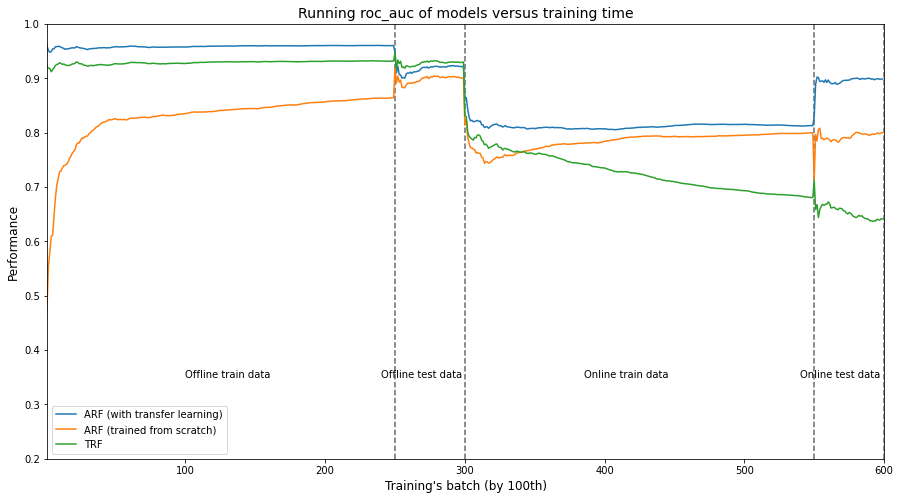

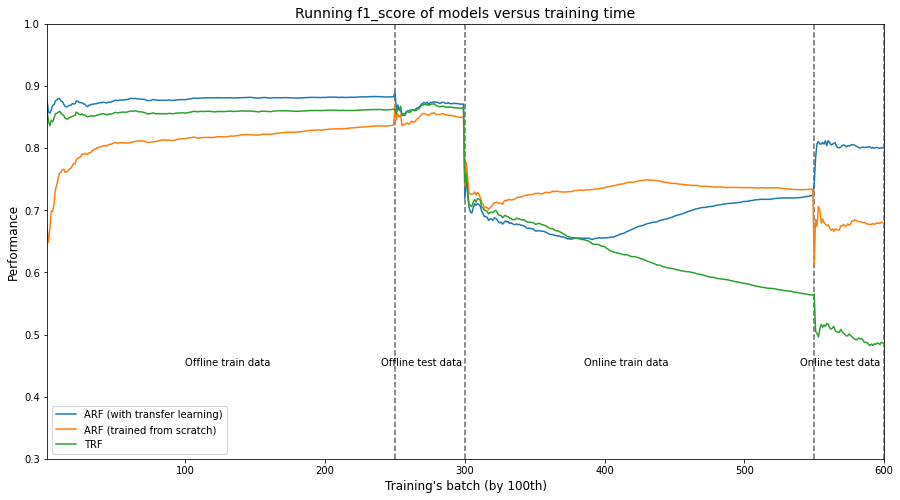

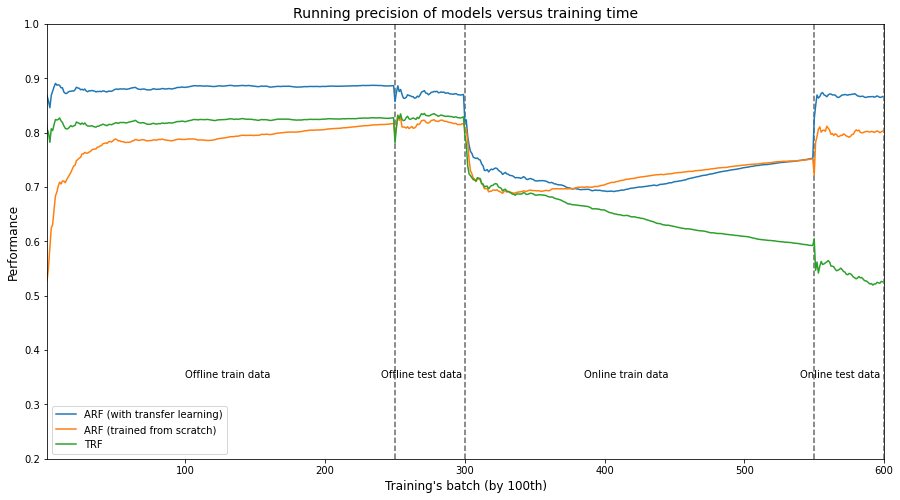

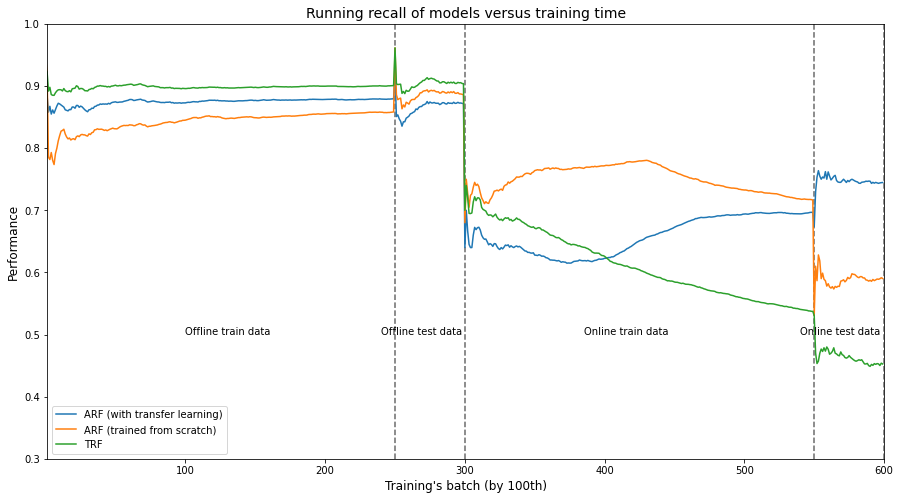

In [20]:
run_metrics_list = {
    'ARF (with transfer learning)': running_metrics_arf,
    'ARF (trained from scratch)': running_metrics_new_arf,
    'TRF': running_metrics_trf,
}

params = {
    'metrics_list': run_metrics_list, 
    'y_train_size': len(y_train),
    'y_test_size': len(y_test),
    'data_interval': DATA_INTERVAL,
    'text_x_positions': [0.4, 0.8, 0.7, 0.9]
}

text_y_positions = [0.35, 0.45, 0.35, 0.5]
ylimits = [[0.2, 1.0], [0.3, 1.0], [0.2, 1.0], [0.3, 1.0]]

# Plot graphs by the type of metrics
for idx, metric_name in enumerate(['roc_auc', 'f1_score', 'precision', 'recall']):
    params['metric_type'] = metric_name
    params['text_y_position'] = text_y_positions[idx]
    params['ylimit'] = ylimits[idx]
    plot_performance_graph(**params)

# Conclusion

As a conclusion, the experiment verifies that:
1. The pre-trained ARF classifier's classification performance is at least good or better than ARF classifier that is trained from scratch in both offline settings and online settings. 
2. The performance of the ARF classifier is at least good or better than TRF classifier during initial training. This is done by "copying" the tree structure from TRF classifier to ARF classifier.
3. The performance of the ARF classifier is better than TRF classifier under the influence of data drift or concept drift.

As the drift occured, both models' performance degraded over time. It can be cleary observed that the rate of decrease in performance was more rapid in the TRF model as compared to ARF models. It is because for every base learner in the ARF ensemble, a new background tree is created and trained along with the current tree as soon as the warning drift detector detect any changes. Then, the drift detector will replace the current tree with the background tree if the change is detected again. This can be proven by comparing the number of nodes and height of each base learner before and after the online training.